# Implementing, training, and analyzing recurrent neural networks
### Brandon McMahan & Jonathan Kao

### For the CalTech DataSAI Summer School, July 15, 2022.

These notebooks will walk you through an introduction to PyTorch for implementing and training neural networks. We will then walk you through implementing, training, and analyzing a recurrent neural network for performing the context-dependent integration (CDI) task in _Mante V, Sussillo D, Shenoy KV, Newsome WT. Context-dependent computation by recurrent dynamics in prefrontal cortex. Nature. 2013;503: 78–84._



In [1]:
# import the necesary modules
import numpy as np
from random import randrange
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import tqdm
from torch.utils.data import DataLoader

# set device
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# 1. Brief Introduction To Working in PyTorch

The first part of this notebook will guide you through some of the basics in PyTorch. We are going to look at the ability of PyTorch to compute gradients as well as how to construct a simple neural network in PyTorch to do classification on MNIST digits.



## Automatic Differentiation 

PyTorch provides a library for deep learning by allowing you to perform operations on tensors (similiar to numpy ndarrays) and automatically keeping track of the gradients during these operations. This allows you to automatically backwards pass through any computational graph/network that you build when using PyTorch. 

PyTorch therefore provides a great way of implementing and training deep neural network architctures. We will start by examining the automatic differentation capabilities of PyTorch. To do this, the below cell will demonstrate how we can define a function (or a forward computation graph) on tensors. Then it will demonstrate how to backward pass the gradients such that we may compute the derivatives. In the second codeblock we will leave it as an exercise to implement a forward pass function and backpropogate the derivatives using PyTorch!

for more details check out: https://pytorch.org/tutorials/beginner/basics/autograd_tutorial.html#computing-gradients

In [2]:
# Define a function and backward propogate it to get the derivatives
# We will compute the function f(x) = 3x^2 + 6x - 5
# and then evaluate this function at f'(0) and f'(-1)

x = torch.tensor([0., -1.], requires_grad=True)
f_x = 3*x**2 + 6*x - 5  
f_x.backward(gradient=torch.tensor([1.,1.]))

# now check that the gradients are correct
print("f'(0) ={0}\nf'(-1)={1}".format(x.grad[0], x.grad[1]))


f'(0) =6.0
f'(-1)=0.0


### Now its your turn to use PyTorch's automatic backpropogation

Try implementing the function below and using automatic differentation to compute the derivaties at the values specified

In [3]:
## You will implement a function and use the PyTorch autograd library to compute
## the derivatives.
## 
## First, define the following function using PyTorch Tensors:
##
## h(x, y) = g(f(x, y)) where,
## g(z) = tanh(z)
## f(x,y) = xy 
## where x, and y are matrices and xy represents the matrix multiplication
##
## HINT: to multiply two matrices in PyTorch you may use X@Y or torch.matmul(x,y)

x = torch.tensor([[.7,-.3,-.4],[-.9,.2,.3]], requires_grad=True)  # x is a 2x3 matrix
y = torch.tensor([[1.],[0.],[1.]], requires_grad=True)      # y is a 3x1 matrix

########
## TODO: 
##    Implement the function to compute h(x,y) for the provided values of x and y
##    Store the comptued value as the variable h_x_y.  There will have an assertion check to be sure you implemented it correctly.
########

## BEGIN SOLUTION
pass
f_x_y = torch.matmul(x, y)
h_x_y = torch.tanh(f_x_y)
## END SOLOTUION

#########
## CHECK:
#########

assert torch.abs(torch.sum(h_x_y - torch.tensor([[ 0.2913],[-0.5370]]))) <= 1e-2, 'You did not calculate h_x_y correctly.'

In [4]:
## Next, you will calculate the gradients of h(x,y) with respect to both x and y.

########
## TODO: 
##    Use the autograd library to get the gradients of dh/dx and dh/dy.
########

## BEGIN SOLUTION
pass
h_x_y.backward(gradient=torch.tensor([[1.],[1.]]))
## END SOLUTION

#########
## CHECK:
#########

assert torch.abs(torch.sum(x.grad - torch.tensor([[0.9151, 0.0000, 0.9151],[0.7116, 0.0000, 0.7116]]))) <= 1e-2, 'dh/dx incorrect.'
assert torch.abs(torch.sum(y.grad - torch.tensor([[ 0.0002], [-0.1322], [-0.1526]]))) <= 1e-2, 'dh/dx incorrect.'

## How to use subclassing to Create Neural Network models in PyTorch

Now that you understand and have used PyTorch to automatically compute the gradients we are ready to build a simple neural network in PyTorch. 

To create a neural network model in PyTorch we will make a subclass from the nn.Module class. If you are not familiar with object oriented programming, don't worry, all you need to do is use the boilerplate code in the cell below. 

Effectively, all you need to do to create a neural network in PyTorch is define all the layers inside the __init__ function (this initializes your neural network) and you need to define the forward pass inside the forward function.  

In short, to create a neural network in PyTorch we do the following: 

1.   Use the boilerplate code below to inherit from the PyTorch nn.Module class
2.   We need to initialize our model with all of its weights in __init__
3.   Define the forward pass

We will walk through the below example together before you create your own  neural network in the next exercise.



In [ ]:
class ExampleNeuralNetwork(nn.Module):
  '''
  This is the implementation of a single layer neural network:
  y = ReLU(Wx + b)
  '''
  def __init__(self):
    # weight matrix
    super(ExampleNeuralNetwork, self).__init__()
    self.W = Variable(torch.randn((100, 28)), requires_grad=True)
    # bias vector
    self.b = Variable(torch.rand((1,100)), requires_grad=True)

  def forward(self, x):
    z = torch.matmul(x, torch.transpose(self.W, 1, 0))  # batch_size, 100
    z = z + self.b
    return F.relu(z)  # F is the torch.nn.functional class.



### Now its your turn to make a simple model in PyTorch

Now that you have seen how to build a neural network model in PyTorch, you can practice doing this yourself!


Now try building a simple linear network with a relu activation and 10 output classes.

You will use two layers. Each layer will have its own weight and bias. The first layer should map an input from 28 to 100 dimensions. The outputs of this layer should use a ReLU activation.

The second layer should map an input from 100 down to 10 dimensions. This layer should use a SoftMax activation.

In [ ]:
class ExampleTwoLayerNetwork(nn.Module):
  '''
  This should implement a two layer neural network similiar to the single layer 
  neural network defined above. This network will have two layers. Both layers 
  should use a ReLU activation function and both layers should have weights and 
  biases

  This network should accept an input with 784 input features.
  The hidden layer should have 128 units
  The output size should be 10 and should use a softmax activation
  '''

  def __init__(self):
    # initializes the base class (dont worry if you haven't seen OOP)
    super(ExampleTwoLayerNetwork, self).__init__()
    # sets a random seed for comparison purposes
    torch.manual_seed(12345)

    ########
    ## TODO:
    ##    Define and initialize all the weights and biases.
    ##    Your weight matrices should all be initialzed from a random normal 
    ##    distribution and your bias vectors should be initialzed from a random
    ##    uniform distribution. Name these as class variables, e.g., 
    ##    
    ##      self.W1 = Variable(torch.randn(...))
    ##
    ##    And name them self.W1, self.b1, self.W2, and self.b2.
    ##
    ##    HINT: Use torch.randn() and torch.rand() to do these initializations.
    ########

    ## BEGIN SOLUTION
    pass
    # layer 1 parameters
    self.W1 = Variable(torch.randn((128, 784)), requires_grad=True)
    self.b1 = Variable(torch.rand((1,128)), requires_grad=True)
    # layer two parameters
    self.W2 = Variable(torch.randn((10, 128)), requires_grad=True)
    self.b2 = Variable(torch.rand((1,10)), requires_grad=True)
    ## END SOLOTUION

    self._params = [self.W1, self.b1, self.W2, self.b2]
    
  def forward(self, x):
    
    ########
    ## TODO:
    ##    Implement the two layer forward pass.
    ##    x is the input to the neural network, and this function should return
    ##    the output of the network.
    ########

    ## BEGIN SOLUTION
    pass
    z1 = torch.matmul(x, torch.transpose(self.W1, 1, 0))  # batch_size, 100
    a1 = F.relu(z1 + self.b1)

    z2 = torch.matmul(a1, torch.transpose(self.W2, 1, 0))  # batch_size, 100
    a2 = F.softmax(z2 + self.b2)
    return a2
    ## END SOLOTUION
    

## Training and Inferencing from trained Neural Networks

We will walk through the code below to give an idea of how all this can be put together to write a simple training loop in pytorch.

In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

# create an instance of our neural network
my_net = ExampleTwoLayerNetwork()
my_net = my_net

# load mnist data
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# prepare data loaders
train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

# define a loss and an optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(my_net._params, lr=0.1, momentum=0.9)

# used to compute accuracy at end of each epoch
def get_accuracy(pres, labels):
    n_correct = torch.sum(labels == torch.argmax(preds, dim=-1))
    n_total = labels.shape[0]
    return n_correct / n_total

# train on MNIST data for a few (5-10) epochs
for epoch in range(5):
    print("epoch #{0}".format(epoch))
    for img, labels in tqdm.tqdm(train_loader):
        img = img.view(-1,784)
        optimizer.zero_grad()
        pred = my_net(img)
        loss = loss_fn(pred, labels)
        loss.backward()
        optimizer.step()

    # get the accuracy on the test set \
    my_net.eval()
    n_correct = 0
    n_total = 0
    for img, labels in test_loader:
        img = img.view(-1,784)
        preds = my_net(img)
        n_correct += torch.sum(labels == torch.argmax(preds, dim=1))
        n_total += labels.shape[0]
    print("validation accuracy: {:.2f}%".format(100*n_correct/n_total))
    my_net.train()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

epoch #0


100%|██████████| 938/938 [00:14<00:00, 62.66it/s]


validation accuracy: 39.28%
epoch #1


100%|██████████| 938/938 [00:11<00:00, 79.37it/s] 


validation accuracy: 43.87%
epoch #2


100%|██████████| 938/938 [00:07<00:00, 126.00it/s]


validation accuracy: 46.51%
epoch #3


100%|██████████| 938/938 [00:07<00:00, 127.37it/s]


validation accuracy: 46.45%
epoch #4


100%|██████████| 938/938 [00:07<00:00, 129.26it/s]


validation accuracy: 47.24%


# 2. Implementation: RNN architecture and forward pass.

Now that you have some experience with PyTorch, we will walk you through implementing the RNN architecture and forward pass. Instead of having you implement the classes, which could be harder to debug, we've asked you to implement functions inside the class separately in these cells below. 
We will implement each of the functions seperately as code blocks and then stitch everything together at the end into a single RNN class later.

This part of the notebook will guide you through implementing the architecture and forward pass of the recurrent neural network. After we define the forward pass, we can rely on PyTorch's autodifferentiation capabilities (loss.backward()) to compute all the gradients for us. (Note that TensorFlow also has this.)


## RNN initialization and forward pass

In the following cells, we will initialize the RNN's parameters and write the forward pass of the RNN.



### Network initialization

In the following cell, we initialize all variables that will be used to compute the RNN forward pass.

In [ ]:
## Input hyperparameters

inputSize = 2       # number of inputs
hiddenSize = 5      # number of artificial neurons
outputSize = 1      # of outputs

## Later on, self.device in the RNN class will be set to either "cpu" (to do all computations on the cpu) 
## or "cuda:0" (to do computations on GPU).

device = "cpu"

## Initialization hyperparameter for W_rec, usually g = 1.

g = 1

## Hyperparameters for the variance of the weight initialization for the input and output weight matrices.

inputSigma = 0.5      # input weights standard deviation
outputSigma = 0.1     # output weights standard deviation
biasScale = 0         # value of the biases


Next, you will implement the initialization of all the weights and biases.

In [ ]:
## Initialize W["in"], W["rec"], W["out"], and biases. These will be stored in the dictionary W.

########
## TODO:
##
##   Initialize all the weights, which are stored in the dictionary W.
##
##   The RNN equation is:
## 
##     x_{t+1} = (1-alpha) * x_t + (1-alpha) * (W_{rec} * f(x_t) + W_in * u_t + bias)
##
##   Here, the matrices are:
##     W_{in} is W["in"]
##     W_{rec} is W["rec"]
##     W_{out} is W["out"]
##     bias is self_W["bias"]
##
##   The initializations should be:
##     W_{in} ~ N(0, (inputSigma)^2)
##     W_{rec} ~ N(0, (g**2 / hiddenSize)^2)
##     W_{out} ~ N(0, (outputSigma)^2)
##     bias ~ N(0, biasScale) 
##
##   Note 1: these should all be Torch tensors (not numpy arrays!)
##   Note 2: for this implementation, bias should be of size (hiddenSize,).
##
##   To make all of these CUDA compatible (i.e., able to run on GPU), append ".to(device)" after.
##   While these will run on the CPU, later on, this will enable us to run on the GPU if self.device in the RNN class is set to the GPU.
##    
##   EXAMPLE:
##
##     W['in'] = inputSigma * torch.randn(hiddenSize, inputSize)
##       becomes
##     W['in'] = (inputSigma * torch.randn(hiddenSize, inputSize)).to(device)
##
##   Lastly, as we will do a check to make sure you initialized correctly, you should only make 
##    three calls to torch.randn; one for W_{in}, W_{rec}, and W_{out}
##
########

# Set the random seed so our results are comparable.

torch.manual_seed(0)
W = []

## BEGIN SOLUTION
pass
W = {
    'in' : torch.randn(hiddenSize, inputSize).to(device)*inputSigma,
    'rec' : ((g**2)/hiddenSize)*torch.randn(hiddenSize, hiddenSize).to(device),
    'out' : (outputSigma*torch.randn(outputSize, hiddenSize).to(device)),
    'bias' : torch.zeros(hiddenSize,).to(device)*biasScale,
    }

## END SOLUTION

#### Initialization implementation check

Run the following code to check your initialization dimensions and values. Because we set the random seed, you should get the same results. 

All the assertions should pass if your initializations are correct.

In [ ]:
#########
## CHECK:
#########

assert W["in"].numpy().shape == (hiddenSize, inputSize), "Dimensions of W_in are incorrect."
assert W["rec"].numpy().shape == (hiddenSize, hiddenSize), "Dimensions of W_rec are incorrect."
assert W["out"].numpy().shape == (outputSize, hiddenSize), "Dimensions of W_out are incorrect."
assert W["bias"].numpy().shape == (hiddenSize,), "Dimensions of bias are incorrect."
assert torch.is_tensor(W["in"]), "W_in is not a torch.FloatTensor"
assert torch.is_tensor(W["rec"]), "W_rec is not a torch.FloatTensor"
assert torch.is_tensor(W["out"]), "W_out is not a torch.FloatTensor"
assert torch.is_tensor(W["bias"]), "bias is not a torch.FloatTensor"

In [ ]:
#########
## CHECK:
#########

assert torch.sum(torch.abs(W['in'] - torch.tensor((( 0.7705, -0.1467), (-1.0894,  0.2842), (-0.5423, -0.6993), ( 0.2017,  0.4190), (-0.3596, -0.2017))))) <= 1e-2, "W_in initialization is not correct"
assert torch.sum(torch.abs(W['rec'] - torch.tensor((( 0.1198, -0.3110, -0.0683,  0.3706,  0.0936), (-0.0315,  0.2887,  0.0532,  0.2779, -0.1357), ( 0.1877,  0.0978, -0.1346,  0.1746,  0.2111), ( 0.0356, -0.0461, -0.0613, -0.3162,  0.3413), (-0.0892,  0.1488,  0.3042,  0.6821, -0.3062))))) <= 1e-2, 'W_rec initialization is not correct'
assert torch.sum(torch.abs(W['out'] - torch.tensor(((-0.0531, -0.0431, -0.2286,  0.0070,  0.0667))))) < 1e-2, 'W_out initialization is not correct'

### RNN Forward pass

We will now implement the RNN forward pass. Note that while in the earlier PyTorch example we had a single function to forward pass the inputs, here we will define three functions. We will define a ```updateHidden``` function that directly updates the hidden state. We will write a ```forward``` function which passes a single input forward through the RNN and lastly we will implement a ```feed``` function which passes an entire mini-batch of inputs forward through the RNN.


#### Implement hidden state update for one time step



In this section, you will now write a function, "hidden_next = updateHidden(hidden_current, inpt)" that takes in one set of RNN inputs and computes the next hidden state. When we say hidden_state here, we are referring to the pre-activation hidden state, x, and not f(x) (where f is the nonlinearity). To calculate the next hidden_state requires the current hidden state. This update is just for ONE time step and one input. We will later use these functions to calculate all the hidden states and outputs across all time.

In [1]:
def updateHidden(hidden_current, inpt):

    '''Updates the hidden state of the RNN for one time step.
        
        Parameters
        ----------
        hidden_curent: PyTorch Tensor
            current hidden state
        inpt: PyTorch Tensor
            inputs to the network at current time step. Has shape (inputSize, batchSize)

        Returns
        -------
        hidden_next: PyTorch cuda Tensor
            Tensor of the updated neuron activations. Has shape (hiddenSize, batchSize)

    '''
    
    
    ########
    ## TODO: 
    ##    Implement one time step to update the hidden activation.
    ##      x_{t+1} = (1-alpha) * x_t + alpha * (W_{rec} * f(x_t) + W_in * u_t + bias)
    ##    
    ##    For this question, we will assume that alpha = 1/dt. We will also assume
    ##    that f() is tanh().
    ##
    ##    This function returns "hidden_next".
    ########

    dt = 10
    alpha = 1/dt
    f = torch.tanh

    ## BEGIN SOLUTION
    pass
    # forward pass through the network
    hidden_next = alpha*torch.matmul(W["in"], inpt) + \
        alpha*torch.matmul(W['rec'], f(hidden_current)) + \
        (1-alpha)*hidden_current + alpha*W['bias']
    
    ## END SOLUTION
    
    return hidden_next
    

#### updateHidden implementation check

The following checks your implementation of updateHidden.

Be sure that W is one that passed all the prior implementation checks.

In [ ]:
#########
## CHECK:
#########

torch.manual_seed(0)

hidden_current = torch.randn((hiddenSize,))
inpt = torch.randn((inputSize,))
hidden_next = updateHidden(hidden_current, inpt)
assert torch.sum(torch.abs(hidden_next - torch.tensor(((1.3113, -0.0915, -1.8936,  0.4674, -0.9165))))) <= 1e-2, "updateHidden() is not correct"

#### Compute output for one time step

Next, we will compute the output of the RNN for an input. You should use the updateHidden() function here. Be sure your updateHidden() passed the implementation check.

Computing the output given the inputs is typically called the forward pass, and so this function is called "forward".


In [ ]:
def forward(hidden_current, inpt):
    '''
    Computes the RNNs forward pass output for a single timestep

    Parameters
    ----------
    hidden_curent: PyTorch Tensor
        current hidden state
    inpt: PyTorch Tensor 
        inputs to the network for the current timestep. Shape (inputSize, batchSize)

    Returns
    -------
    output: PyTorch Tensor
        output of the network after this timestep. Has shape (outputSize, batchSize)
    hidden_next: PyTorch Tensor
        copy of the hidden state activations after the forward pass. Has shape
        DESCRIPTION.(hiddenSize, batchSize)

    '''
    
    # assert that inputs are torch tensors 
    assert torch.is_tensor(hidden_current), "Current hidden state is not a torch tensor."
    assert torch.is_tensor(inpt), "Input is not a torch tensor."


    ########
    ## TODO: 
    ##    Compute the output of the RNN, which for this notebook is is W['out']@hidden_next.
    ##    
    ##    HINT: Use updateHidden() to compute hidden_next.
    ########

    ## BEGIN SOLUTION
    pass
    hidden_next = updateHidden(hidden_current, inpt)
    output = torch.matmul(W['out'], hidden_next)

    ## END SOLUTION

    return output, hidden_next.clone()

    

#### Forward implementation check

This checks your implementation of forward. Be sure that updateHidden() passed its check.

In [ ]:
#########
## CHECK:
#########

torch.manual_seed(0)

hidden_current = torch.randn((hiddenSize,))
inpt = torch.randn((inputSize,))
output, hidden_next = forward(hidden_current, inpt)
assert torch.sum(torch.abs(hidden_next - torch.tensor(((1.3113, -0.0915, -1.8936,  0.4674, -0.9165))))) <= 1e-2, "forward() hidden_next is not correct"
assert torch.abs(output - 0.3093) <= 1e-3, 'forward() output is not correct'

#### Now compute all hidden states and outputs for all time steps

We will now use the forward() function you implemented to compute the forward pass for all time steps. We will call this function "feed()".

In [ ]:
## Note that in the class, our feed function will also be able to take batches of data
## but in this case, we'll just do it for one batch.

def feed(inpt_data):
    '''
    Feeds an input data sequence into an RNN

    Parameters
    ----------
    inpt_data : PyTorch Tensor
        Inputs sequence to be fed into RNN. Has shape (Time, inputSize)
        
    Returns
    -------
    output_trace : PyTorch Tensor
        output_trace: output of the network over all timesteps. Will have shape 
        (T,)
    hidden_states : PyTorch Tensor
        hidden_states: pre-activation hidden states of the network through a trial, has shape
        (T, hiddenSize)

    '''

    T = inpt_data.shape[0]
    inputSize = inpt_data.shape[1]

    # Normally the hidden size and output size are stored as class variables. For this function, we will 
    # simply define output_trace for a 1D output, and assume the hiddenSize is 5, continuing our example above.
    # These are hard-coded in, but in the class, they will be stored as e.g. self.hiddenSize.
    
    output_trace = torch.zeros(T)
    hidden_states = torch.zeros((T,5))
    hidden_current = torch.zeros((5,))
    
    hidden_states[0, :] = hidden_current

    ########
    ## TODO:
    ##    Compute hidden_states and output_trace across all time for the RNN.
    ##    
    ##    HINT: You should write a for loop over T, and repeatedly call forward().
    ########

    ## BEGIN SOLUTION
    pass
    for t_step in range(len(inpt_data)):
        output, hidden_next = forward(hidden_current.clone(), inpt_data[t_step])
        output_trace[t_step] = output
        hidden_states[t_step, :] = hidden_next

    ## END SOLUTION
    return output_trace, hidden_states

#### Feed implementation check

The following checks the implementation of feed(). Be sure forward() passed the implementation check.

In this case, we will just check that you got the value of output_trace correct.


In [ ]:
#########
## CHECK:
#########

T = 10

torch.manual_seed(0)
inpt_data = torch.randn((T, inputSize)) # of dimensions (Time, inputSize)

output_trace, hidden_states = feed(inpt_data)
assert torch.sum(torch.abs(output_trace - torch.tensor((-0.0288, -0.0090, -0.0161,  0.0232,  0.0027,  0.0194,  0.0379, -0.0021, 0.0282,  0.0223)))) <= 1e-2, "feed() output_trace is not correct"

# 3. Building the Training Data Pipeline

Now that the RNN weights and forward pass have been implemented, next we are going to create our training data. We will be training these RNNs to perform the Context Dependent Integration (CDI) task as desribed in Mante and Susillo 2013. 

### Generate random input

The CDI task provides a 1D input for each of the context and color signals with some specified mean (random dots coherence) and noise (random dots noise). Our first function will therefore generate a 1D input at a mean.

This function will also have a trial_prob, which allows us to specify whether the mean is positive (if a random number is less than trial_prob) or negative (random number greater than trial_prob).

In [ ]:


def random_generate_input(mean, trial_prob=0.5, T=750):
        '''
        Generates a 1D noisy signal for a context with the provided mean. 
        
        Parameters
        ----------
        mean : float
          the mean value of the noisy context signal
        trial_prob : float
          the probability that this trial shoudl be positive
        T : float
          the amount of timesteps to generate the random 

        Returns
        -------
        context_input : torch tensor
          Noisy context signal with dimensions (750,)
        
        The 
        chance of a positive trial is given by trial_prob.
        '''
        
        context_input = None

        ########
        ## TODO: 
        ##    Compute context_input, a T length torch tensor.  This is a 1D 
        ##    input with a certain mean and noise added, where the noise is unit 
        ##    Gaussian noise (i.e., simply call torch.randn()).
        ##
        ##    You will randomly determine if the mean will be positive or negative
        ##    in the following way: when torch.rand(1).item() < trial_prob, the 
        ##    mean of context_input should be mean, else it should be -mean.
        ##  
        ##    The additive noise is unit Gaussian. 
        ##
        ########


        ## BEGIN SOLUTION
        pass
        
        # with probability trial_prob generate a positive trial
        if torch.rand(1).item() < trial_prob:
          context_input = mean*torch.ones(T)
        else:
          context_input = -mean*torch.ones(T)  
           
        # add noise to the signal
        context_input += torch.randn(T)  
        
        ## END SOLUTION

        return context_input

#### Generate random inputs check

This check makes sure you implemented random_generate_input correctly.

In [ ]:
#########
## CHECK:
#########

torch.manual_seed(0)
T = 5 # the number of time steps to generate the input for; Mante and Sussillo use 750, we're using 5 for the sanity check
mean = 0.18
trial_prob = 0.5

context_input = random_generate_input(mean, trial_prob=trial_prob, T=T)
assert torch.sum(torch.abs(context_input - torch.tensor((0.3872, 0.4499, 0.7307, 0.4504, 0.8272)))) <= 1e-2, "random_generate_input() context_input is not correct"

### Generate CDI task inputs

Now, we will use the above function to generate a single trial of data for the CDI task. This will return the perceptual input data as well as the labels. There will be 2 inputs, though this can be controlled through the input N_INPUT_CHANNELS. We will also use the max_mean of 0.18 that is used in the paper. Note that while these are inputs to GetInput(), they will be class variables in the class implementation.


In [ ]:
def GetInput(mean_override=None, T=750, N_INPUT_CHANNELS=2, max_mean=0.18):
        '''
        Generates a single trial of data for the CDI-task. Returns the
        perceptual data (inpts) and the labels (target)
random_generate_input

        Parameters
        ----------
        mean_override : float, optional
            The default is None. Specifying a value allows you to generate a trial with a particular mean.
        
        T : int, optional
            The default is 750. This is the time length of an input.

        N_INPUT_CHANNELS : int, optional
            The default is 2. This is the number of sensory inputs. This is a class variable in the class implementation.

        max_mean : float, optional
            The default is 0.18, which is what Mante & Sussillo implemented. It is the maximum mean for an input. 

        Returns
        -------
        inpts : PyTorch CUDA Tensor
            A (T, 2*N_INPUT_CHANNELS) input for this trial. See comments below for further description.
        target : PyTorch CUDA float
            A float +1 if the context is 1 and -1 if context is 2.
        '''

        # allows caller to use a deterministic mean for this trial
        if mean_override is not None:
            mean = mean_override


        #  The inputs are, for N_INPUT_CHANNELS=2 (generalizes intuitively to higher N):
        #
        #  inpts[:,0] is channel 1's random input of length T
        #  inpts[:,1] is channel 2's random input of length T
        #  inpts[:,2] is 1 if the context is channel 1, 0 otherwise.
        #  inpts[:,3] is 1 if the context is channel 2, 0 otherwise.
        #
        #  The channel that the input pays attention (1 or 2) is randomly drawn.
        #  The target is a float that is +1 if the mean for the correct channel is positive, -1 if it is negative.
      
        inpts = torch.zeros((T, 2*N_INPUT_CHANNELS))

        ########
        ## TODO: 
        ##    If mean_override is not used, then generate a randomly sampled mean
        ##    uniformly over U[-max_mean, max_mean]. Else, the mean will equal
        ##    mean_override.
        ##
        ##    After that, generate the variable inpts as described in the 
        ##    comment above. Pick randomly with equal probability whether the 
        ##    context is channel 1 or 2.
        ##
        ##    HINT: Generate the random inputs using random_generate_input().
        ########

        # BEGIN SOLUTION

        pass
        # sample trial mean from ~U[-max_mean, max_mean]
        if mean_override is None: 
            mean = torch.rand(1).item() * max_mean

        # randomly sets one of the channels to be on
        go_channel = torch.randint(low=0, high=N_INPUT_CHANNELS, size=(1,))
        for channel_num in range(N_INPUT_CHANNELS):
            inpts[:,channel_num] = random_generate_input(mean, T=T)
            # generate the GO signals
            if go_channel == channel_num:
                inpts[:, N_INPUT_CHANNELS + channel_num] = 1
                target = torch.sign(torch.mean(inpts[:, channel_num]))
            else:
                inpts[:, N_INPUT_CHANNELS + channel_num] = 0

        
        # adds noise to inputs
        inpts[:,:N_INPUT_CHANNELS] += torch.randn(T, 
            N_INPUT_CHANNELS)
        return inpts, target
      

### GetInput check

The following code checks your implementation of GetInput(). Be sure that you passed the validation of random_generate_input().

In [ ]:
#########
## CHECK:
#########

torch.manual_seed(0)
inpts, target = GetInput(T=5)
assert torch.sum(torch.abs(inpts - torch.tensor((( -0.4030,  1.9169,  0.0000,  1.0000), (-0.8475, -0.6859,  0.0000,  1.0000), (-0.3128, -0.1196,  0.0000,  1.0000), (-0.4969, -2.1951,  0.0000,  1.0000), (0.6697,  1.5492,  0.0000,  1.0000))))) <= 1e-1, 'GetInputs() inpts are not correct'
assert torch.abs(target + 1) <= 1e-2, 'GetInputs() target not correct'

# 4. Import our RNN and CDI class. 

Congratulations on implementing the functions needed to build an RNN and perform the CDI task! We will now import the RNN and CDI classes we implemented, which contains all the functions you have implemented. For now, just understand that we have done something close to copying and pasting the functions implemented above into classes.

While the implementation of these functions will be very similar to the code you wrote above, there will be some minor differences (such as feed() taking in batches of data instead of one sequence). To know how to call them, including the inputs and the dimensions of them, you will likely have to refer to these cells every now and then.

Please run the cell below, collapsed for convenience / to avoid clutter. Expand this cell to read the class variables and functions of the RNN and CDI class.


In [ ]:
class RNN(nn.Module):
    # recently changed var by normalizing it by N, before was 0.045 w/o normilazation
    def __init__(self, hyperParams, task, device='cuda:0'):
        #self._device = torch.device("cpu")
        #if torch.cuda.is_available():
        self._device = torch.device(device)
        super(RNN, self).__init__()                                            # initialize parent class
        self._inputSize = int(hyperParams["inputSize"])
        self._hiddenSize = int(hyperParams["hiddenSize"])
        self._outputSize = int(hyperParams["outputSize"])
        self._g = hyperParams["g"]
        self._hiddenInitScale = hyperParams["initScale"]                       # sets tolerance for determining validation accuracy# initializes hidden layer                                                   # sets noise for hidden initialization
        self._dt= hyperParams["dt"]
        self._batchSize = int(hyperParams["batchSize"])
        self._hParams = hyperParams                                             # used for saving training conditions
        self._init_hidden()   
        self._totalTrainTime = 0                                               # accumulates training time
        self._timerStarted = False
        self._useForce = False            # if set to true this slightly changes the forward pass 
        self._useHeb = False
        self._fixedPoints = []
        self._tol = 1
        
        self._J = {
        'in' : Variable(torch.randn(self._hiddenSize, self._inputSize).to(self._device)*(1/2), requires_grad=True),
        'rec' : Variable(((self._g**2)/50)*torch.randn(self._hiddenSize, self._hiddenSize).to(self._device), requires_grad=True),
        'out' : Variable((0.1*torch.randn(self._outputSize, self._hiddenSize).to(self._device)), requires_grad=True),
        'bias' : Variable(torch.zeros(self._hiddenSize, 1).to(self._device)*(1/2), requires_grad=True)
        }

        self._params = [self._J['rec'], self._J['in'], self._J['out'], self._J['bias']]


        try:
            self._use_ReLU = int(hyperParams["ReLU"])             # determines the activation function to use
        except:
            self._use_ReLU = 0
            

        self._task = task

              

        #create an activity tensor that will hold a history of all hidden states
        self._activityTensor = np.zeros((50))
        self._neuronIX = None    #will hold neuron sorting from TCA
        self._targets=[]
        self._losses = 0     #trainer should update this with a list of training losses
        self._MODEL_NAME = 'models/UNSPECIFIED MODEL'   #trainer should update this
        self._pca = []
        self._recMagnitude = []     #will hold the magnitude of reccurent connections at each step of training
        # will hold the previous weight values
        self._w_hist = []    # will hold the previous weight values

        self._valHist = []        # empty list to hold history of validation accuracies

        #self.fractions = []
        #weight matrices for the RNN are initialized with random normal

    def _startTimer(self):
        '''
        starts timer for training purposes

        Returns
        -------
        None.

        '''
        self._tStart = time.time()
        self._timerStarted = True
    
    def _endTimer(self):
        '''
        stops training timer

        Returns
        -------
        None.

        '''
        if self._timerStarted == False:
            return
        else:
            self._totalTrainTime += time.time() - self._tStart
            self._timerStarted = False
    
    def setName(self, name):
        '''
        sets name of model

        Parameters
        ----------
        name : string
            model will be saved as a .pt file with this name in the /models/ directory.

        Returns
        -------
        None.

        '''
        self._MODEL_NAME = "models/" + name
        
    def createValidationSet(self, test_iters=2000):
        '''
        DESCRIPTION:
        Creates the validation dataset which will be used to 
        decide when to terminate RNN training. The validation 
        dataset consists of means sampled uniformly from -0.1875 
        to +0.1875. The variance of all instances in the validation 
        dataset is equal to the variance of the trainign dataset 
        as specified by the task object.
        
        validation dataset has shape (test_iters, numInputs, tSteps)
        
        PARAMETERS:
        **valSize: specifies the size of the validation dataset to use
        **task: task object that is used to create the validation data 
        set
        '''
        # initialize tensors to hold validation data
        self.validationData = torch.zeros(test_iters, self._inputSize,  self._task.N).to(self._device)
        self.validationTargets = torch.zeros(test_iters,1).to(self._device)
        # means for validation data
        meanValues = np.linspace(0, 0.1875, 20)
        for trial in range(test_iters):
            # to get genetic and bptt different I divided by 30
            mean_overide = meanValues[trial %20]
            inpt_tmp, condition_tmp = self._task.GetInput(mean_overide=mean_overide)
            self.validationData[trial,:, :] = inpt_tmp.t()
            self.validationTargets[trial] = condition_tmp
        print('Validation dataset created!\n')

    def GetValidationAccuracy(self, test_iters=2000):
        '''
        Will get validation accuracy of the model on the specified task to 
        determine if training should be terminated
        '''
        accuracy = 0.0
        tol = self._tol

        inpt_data = self.validationData#.t()
        condition = self.validationTargets
        condition = torch.squeeze(condition)
        output = self.feed(inpt_data)
        output_final = torch.sign(output[-1,:])
        # scale ouput in the case of multisensory network
        # compute the difference magnitudes between model output and target output
        #if isinstance(self._task, DMC):
        #    differences = self.validationTargets-output_final.view(-1,1)
        #    num_errors = torch.sum(torch.abs(differences) > 0.15).item()
        #else:
        error = torch.abs(condition-output_final)
        # threshold this so that errors greater than tol(=0.1) are counted
        num_errors = torch.where(error>tol)[0].shape[0]
        accuracy = (test_iters - num_errors) / test_iters

        
        self._valHist.append(accuracy)                 # appends current validation accuracy to history
    
        
        return accuracy

    def _UpdateHidden(self, inpt):
        '''Updates the hidden state of the RNN. NOTE: The way the hidden state is updated 
        will vary depending on the task and learning rule the RNN was trained with. 


        Parameters
        ----------
        inpt : PyTorch cuda tensor
            inputs to the network at current time step. Has shape (inputSize, batchSize)
        use_relu : BOOL, optional
            when true, the network will use ReLU activations. The default is False.

        Returns
        -------
        hidden_next : PyTorch cuda Tensor
            Tensor of the updated neuron activations. Has shape (hiddenSize, batchSize)

        '''
        dt = self._dt
        Jin = self._J["in"]

        # set activation function
        if self._use_ReLU:
            act_func = nn.functional.relu
        else:
            act_func = lambda x : 1+torch.tanh(x)

        # forward pass through the network
        noiseTerm=0
        hidden_next = dt*torch.matmul(Jin, inpt) + \
        dt*torch.matmul(self._J['rec'], (1+torch.tanh(self._hidden))) + \
        (1-dt)*self._hidden + dt*self._J['bias'] + 0*noiseTerm

        self._hidden = hidden_next        # updates hidden layer
        return hidden_next

    def _forward(self, inpt):
        '''
        Computes the RNNs forward pass activations for a single timestep

        Parameters
        ----------
        inpt : PyTorch cuda Tensor 
            inputs to the network for the current timestep. Shape (inputSize, batchSize)

        Returns
        -------
        output : PyTorch cuda Tensor
            output of the network after this timestep. Has shape (outputSize, batchSize)
        PyTorch cuda Tensor
            copy of the hidden state activations after the forward pass. Has shape
            (hiddenSize, batchSize)

        '''

        #ensure the input is a torch tensor
        if torch.is_tensor(inpt) == False:
            inpt = torch.from_numpy(inpt).float()                              # inpt must have shape (1,1)
        inpt = inpt.reshape(self._inputSize, -1)
        
        # compute the forward pass
        self._UpdateHidden(inpt)
        if self._useHeb:
            output = torch.tanh(self._hidden[0])
        elif self._useForce:
            output = torch.tanh(torch.matmul(self._J['out'], torch.tanh(self._hidden)))
        else:
            output = torch.matmul(self._J['out'], self._hidden)

        return output, self._hidden.clone()

    def feed(self, inpt_data, return_hidden=False, return_states=False):
        '''
        Feeds an input data sequence into an RNN

        Parameters
        ----------
        inpt_data : PyTorch CUDA Tensor
            Inputs sequence to be fed into RNN. Has shape (batchSize, inputSize, Time)
        return_hidden : BOOL, optional
            When True, the hidden states of the RNN are returned as list of length
            Time where each element is a NumPy array of shape (hiddenSize, batchSize)
            containing the hidden state activations through the course of the input
            sequence. The default is False.

        Returns
        -------
        output_trace : PyTorch CUDA Tensor
            output_trace: output of the network over all timesteps. Will have shape 
            (batchSize, inputSize) i.e. 40x1 for single sample inputs
        hidden_states : PyTorch CUDA Tensor
            hidden_states: hidden states of the network through a trial, has shape
            (batch_size, time_steps, hidden_size)

        '''

        #num_inputs = len(inpt_data[0])
        batch_size = inpt_data.shape[0]
        inpt_seq_len = inpt_data.shape[-1]
        assert inpt_data.shape[1] == self._inputSize, "Size of inputs:{} does not match network's input size:{}".format(inpt_data.shape[1], self._inputSize)
        num_t_steps = inpt_data.shape[2]
        
        output_trace = torch.zeros(num_t_steps, batch_size).to(self._device)
        if return_hidden:
            hidden_trace = []
        if return_states:
            hidden_states = torch.zeros((batch_size, inpt_seq_len, self._hiddenSize), requires_grad=True)

        self._init_hidden(numInputs=batch_size)  # initializes hidden state
        inpt_data = inpt_data.permute(2,1,0)     # now has shape TxMxB
        for t_step in range(len(inpt_data)):
            output, hidden = self._forward(inpt_data[t_step])
            if return_hidden:
                hidden_trace.append(hidden.cpu().detach().numpy())      # unsure if there are any dependencies on hidden_trace

            if return_states:
                hidden_states[:,t_step,:] = hidden.T                    # (batch_size, hidden_size)
                
            if self._useHeb:
                output_trace[t_step,:] = hidden.detach()[0]
            else:
                output_trace[t_step,:] = output
        if return_hidden:
            hh = np.array(hidden_trace)
            return output_trace, hh
            
        if return_states:
            return output_trace, hidden_states
        #print('shape of output trace', len(output_trace[0]))
        return output_trace
        

    def save(self, N="", tElapsed=0, *kwargs):
        '''
        saves RNN parameters and attributes. User may define additional attributes
        to be saved through kwargs
        '''
        print('valdiation history', self._valHist)
        if N=="":     # no timestamp
            model_name = self._MODEL_NAME+'.pt'
            print("model name: ", model_name)
        else:         # timestamp
            model_name = self._MODEL_NAME + '_' + str(N) + '.pt'
        if tElapsed==0:
            torch.save({'weights': self._J, \
                        'weight_hist':self._w_hist, \
                        'activities': self._activityTensor, \
                        'targets': self._targets, \
                        'pca': self._pca, \
                        'losses': self._losses, \
                        'rec_magnitude' : self._recMagnitude, \
                        'neuron_idx': self._neuronIX,\
                        'validation_history' : self._valHist,
                        'fixed_points': self._fixedPoints}, model_name)
                
            # save model hyper-parameters to text file
            f = open(self._MODEL_NAME+".txt","w")
            for key in self._hParams:
                f.write( str(key)+" : "+str(self._hParams[key]) + '\n')
            f.write( "total training time: " + str(self._totalTrainTime) + '\n')
            f.close()
            
        else:
            torch.save({'weights': self.J, \
                        'weight_hist':self.w_hist, \
                        'activities': self.activity_tensor, \
                        'targets': self.targets, \
                        'pca': self.pca, \
                        'losses': self.losses, \
                        'rec_magnitude' : self.rec_magnitude, \
                        'neuron_idx': self.neuron_idx, \
                        'fractions' : self.fractions, \
                        'validation_history' : self.valHist, \
                        'tElapsed' : tElapsed,
                        'fixed_points' : self._fixedPoints}, model_name)
        
        #torch.save({'weights': self.J, 'targets': self.targets,  'losses': self.losses,'validation_history' : self.valHist}, model_name)

    def load(self, model_name, *kwargs):
        '''
        Loads in parameters and attributers from a previously instantiated model.
        User may define additional model attributes to load through kwargs
        '''
        # add file suffix to model_name
        fname = model_name+'.pt'
        model_dict = torch.load(fname)
        # load attributes in model dictionary
        if 'weights' in model_dict:
            self._J = model_dict['weights']
            for layer in self._J:  # move weights to correct device
                self._J[layer] = self._J[layer].to(self._device)
        else:
            print('WARNING!! NO WEIGHTS FOUND\n\n')
        if 'activities' in model_dict:
            self._activityTensor = model_dict['activities']
        else:
            print('WARNING!! NO ACTIVITIES FOUND\n\n')
        if 'targets' in model_dict:
            self._targets = model_dict['targets']
        else:
            print('WARNING!! NO TARGETS FOUND\n\n')
        if 'pca' in model_dict:
            self._pca = model_dict['pca']
        else:
            print('WARNING!! NO PCA DATA FOUND\n\n')
        if 'losses' in model_dict:
            self._losses = model_dict['losses']
        else:
            print('WARNING!! NO LOSS HISTORY FOUND\n\n')
        if 'validation_history' in model_dict:
            self._valHist = model_dict['validation_history']
        else:
            print('WARNING!! NO VALIDATION HISTORY FOUND\n\n')
            
        if 'fixed_points' in model_dict:
            self._fixedPoints = model_dict['fixed_points']
            
        # try to load additional attributes specified for kwargs
        for key in kwargs:
            print('loading of', key, 'has not yet been implemented!')

        
        
        
        
        if 'rec_magnitude' in model_dict:
            self.rec_magnitude = model_dict['rec_magnitude']
        else:
            print('WARNING!! NO WEIGHT HISTORY FOUND\n\n')
        if 'neuron_idx' in model_dict:
            self.neuron_idx = model_dict['neuron_idx']
        else:
            print('WARNING!! NO NEURON INDEX FOUND\n\n')

        print('\n\n')
        print('-'*50)
        print('-'*50)
        print('RNN model succesfully loaded ...\n\n')


    # maybe I should consider learning the initial state?
    def _init_hidden(self, numInputs=1):
        self._hidden = self._hiddenInitScale*(torch.randn(self._hiddenSize, numInputs).to(self._device))
    
    def GetF(self):
        W_rec = self._J['rec'].data.cpu().detach().numpy()
        W_in = self._J['in'].data.cpu().detach().numpy()
        b = self._J['bias'].data.cpu().detach().numpy()
        ReLU_flag = self._use_ReLU

        def master_function(inpt, relu=ReLU_flag):
            dt = 0.1
            sizeOfInput = len(inpt)
            inpt = inpt.reshape(sizeOfInput,1)
            if relu:
                return lambda x: np.squeeze( dt*np.matmul(W_in, inpt) + dt*np.matmul(W_rec, (np.maximum( np.zeros((self._hiddenSize,1)), x.reshape(self._hiddenSize,1)) )) - dt*x.reshape(self._hiddenSize,1) + b*dt)
            else:
                if self._useHeb: #TODO: update this to incorporate bias
                    def update_fcn(x):
                        x[1] = 1       # Bias from Miconi 2017
                        x[10] = 1
                        x[11] = -1
                        x = np.squeeze( dt*np.matmul(W_in, inpt) + dt*np.matmul(W_rec, (np.tanh(x.reshape(self._hiddenSize,1)))) - dt*x.reshape(self._hiddenSize,1) + b*dt)
                        x[1] = 1       # Bias from Miconi 2017
                        x[10] = 1
                        x[11] = -1
                        return x
                    #return lambda x: np.squeeze( dt*np.matmul(W_in, inpt) + dt*np.matmul(W_rec, (np.tanh(x.reshape(self._hiddenSize,1)))) - dt*x.reshape(self._hiddenSize,1) + b*dt)
                    return update_fcn
                elif self._useForce:
                    return lambda x: np.squeeze( dt*np.matmul(W_in, inpt) + dt*np.matmul(W_rec, (np.tanh(x.reshape(self._hiddenSize,1)))) - dt*x.reshape(self._hiddenSize,1) + b*dt)
                else:  # BPTT and GA RNNs
                    return lambda x: np.squeeze( dt*np.matmul(W_in, inpt) + dt*np.matmul(W_rec, (1+np.tanh(x.reshape(self._hiddenSize,1)))) - dt*x.reshape(self._hiddenSize,1) + b*dt)

        return master_function
        
    def plotLosses(self):
        plt.plot(self._losses)
        plt.ylabel('Loss')
        plt.xlabel('Trial')
        plt.title(self._MODEL_NAME)


In [ ]:
class ContextDependentIntegration():
    '''
    This class simulates the Mante and Sussillo 2013 context-dependent 
    integration task described here:

    https://www.nature.com/articles/nature12742
    '''

    N_INPUT_CHANNELS = 2

    def __init__(self, N=750, mean=0.1857, var=0.5, device="cuda:0"):
        # determines if code should run on CPU or GPU
        if torch.cuda.is_available() and device=="cuda:0":
            self._device = torch.device(device)
        else:
            self._device = torch.device("cpu")

        self.N = N                 # number of time steps in a trial
        self._max_mean = mean      # maximum mean value of signal
        self._var = var            # variance of signal
        #self._version = ""        # is this deprecated ??
        #self._name = "Ncontext"   # is this deprecated ??

    def _random_generate_input(self, mean, trial_prob=0.5):
        '''
        Generates a 1D noisy signal for a context with the provided mean. The 
        chance of a positive trial is given by trial_prob.
        '''
        if torch.rand(1).item() < trial_prob:
            return mean*torch.ones(self.N)
        return -mean*torch.ones(self.N)
        
    def GetInput(self, mean_overide=None, var_overide=None):
        '''
        Generates a single trial of data for the CDI-task. Returns the
        perceptual data (inpts) and the labels (target)


        Parameters
        ----------
        mean_overide : TYPE, optional
            DESCRIPTION. The default is 1.

        Returns
        -------
        inpts : PyTorch CUDA Tensor
            DESCRIPTION.
        target : TYPE
            DESCRIPTION.
        '''
        inpts = torch.zeros((self.N, 2*self.N_INPUT_CHANNELS)).to(self._device)
        
        # sample trial mean from ~U[-max_mean, max_mean]
        mean = torch.rand(1).item() * self._max_mean

        # allows caller to use a deterministic mean for this trial
        if mean_overide is not None:
            mean = mean_overide

        # allows caller to override the default noise
        if var_overide is not None:
            var = var_overide
        else:
            var = self._var  

        # randomly sets one of the channels to be on
        go_channel = randrange(self.N_INPUT_CHANNELS)

        # generate inputs for the context channels
        for channel_num in range(self.N_INPUT_CHANNELS):
            inpts[:,channel_num] = self._random_generate_input(mean)
            # generate the GO signals
            if go_channel == channel_num:
                inpts[:, self.N_INPUT_CHANNELS + channel_num] = 1
                target = torch.sign(torch.mean(inpts[:, channel_num]))
            else:
                inpts[:, self.N_INPUT_CHANNELS + channel_num] = 0

        
        # adds noise to inputs
        inpts[:,:self.N_INPUT_CHANNELS] += var*torch.randn(self.N, 
            self.N_INPUT_CHANNELS).to(self._device)
        return inpts, target
      

    def PsychoTest(self, coherence, context=0):
        inpts = torch.zeros((750, 4)).cuda()
        # generates an in-context signal with desired coherence
        inpts[:,0] = coherence*torch.ones(750)                     
        # generates out of context signal with random coherence
        if np.random.rand() < 0.5:
          inpts[:,1] = coherence*torch.ones(750)
        else:
            inpts[:,1] = -coherence*torch.ones(750)


        # sets which context should be attended
        inpts[:, 2+context] = 1    

        inpts[:,:2] += torch.randn(750, 2).cuda()    # adds noise to inputs
        
        return inpts

# 5. Write a training loop

Now we will use the RNN and CDI classes to write a training loop that trains the RNN to do the CDI task. There will be multiple functions we will walk you through implementing:

### loss_fn()
This function will compute the loss between the RNN outputs and the target outputs for the trial

## train_one_batch()
This function will compute the loss and output for the RNN on a single (mini-batch) of trials. 

## train()
This function will pull everything together and train the RNN by looping over (mini-batches) of trials to train the RNN until we attain a validation accuracy of some target threshold (95% accuracy by default)


#### loss_fn()

Implement the loss_fn() below, which accepts a target output (target) and the RNN output (output) and computes the loss used by Mante, Sussillo, et al., which is the squared loss between the target and the output at the first and last time step.

In [ ]:
# Implement the loss function

def loss_fn(target, output):

        '''
        Computes the loss function used by Mante, Sussillo, et al. for a target and RNN output.

        Parameters
        ----------
        target : PyTorch CUDA Tensor 
            Target outputs, of size (batch_size, ).

        output : PyTorCH CUDA Tensor
            RNN outputs, of size (length_of_trial, batch_size).

        Returns
        -------
        SquareLoss : PyTorch CUDA float
            The squared loss used by Mante, Sussillo, et al.
            It's the squared error, computed across all trials.
            SquareLoss for a single trial is (output[0])**2 + (target - output[-1])**2
        '''

        # Extract start and end of output
        y_end = output[-1]
        y_strt = output[0]

        ########
        ## TODO: 
        ##    Compute the SquareLoss using the loss used by Mante & Sussillo.
        ##
        ##    For a single trial, this loss is:
        ##      (output[0])**2 + (target - output[-1])**2
        ##
        ########

        ### BEGIN SOLUTION 
        pass

        squareLoss = (y_end-torch.sign(target))**2 + (y_strt - 0)**2
        SquareLoss = torch.sum( squareLoss, axis=0 )
        ### END SOLUTION

        return SquareLoss  

#### Validation of loss_fn()

Run the following cell to test your implementation of loss_fn()

In [ ]:
#########
## CHECK:
#########

torch.manual_seed(0)

T = 10
num_trials = 100
output = torch.randn((T, num_trials))
target = torch.sign(torch.randn((num_trials)))
sq_loss = loss_fn(target, output)

assert sq_loss - 317.0152 <= 1e-2, 'loss_fn() SquareLoss not correct'

#### Compute the output and loss over a batch using the RNN class

We will first write a function, train_one_batch(), that calculates the loss and output of an RNN on one batch of data. After that you will write the training loop to train the parameters of the RNN. 

To start off, run the next cell which creates an instance of the rnn and task classes.


In [ ]:
hyper_params = {                  # dictionary of all RNN hyper-parameters
   "inputSize" : 4,
   "hiddenSize" : 50,
   "outputSize" : 1,
   "g" : 1 ,
   "inputVariance" : 0.5,
   "outputVariance" : 0.5,
   "biasScale" : 0,
   "initScale" : 0.3,
   "dt" : 0.1,
   "batchSize" : 500,
   "taskMean" : 0.1857,
   "taskVar" : 1,
   "ReLU" : 0
   }

task = ContextDependentIntegration(var=0.8)
rnn = RNN(hyper_params, task)

In [ ]:
# implement the train one epoch function

def train_one_batch(rnn, input, condition):
    '''
    This function computes the output and loss over a batch of data.

    Parameters
    ----------
    input : PyTorch Tensor
        Inputs sequence to be fed into RNN. Has shape 
        (batch_size, sequence_len, inputSize)
    condition : PyTorch Tensor
        Contains the target (task condition) for each trial in this mini-batch. 
        Has shape (batch_size,)
        
    Returns
    -------
    output : PyTorch CUDA Tensor
        Output of the RNN which has shape (batch_size, sequence_len, 1) since 
        there is one output at every timestep for each trial in the mini-batch
    loss : PyTorch CUDA Tensor
        Loss computed over all trials in the mini-batch
    '''


    # parse input dimensions
    batch_size, inpt_seq_len, input_size = input.shape     
    # there will be exactly one output at every timestep (this assumes the output size is 1)
    output = torch.zeros((inpt_seq_len, batch_size)).to(rnn._device)

    trial_length = inpt_seq_len

    ########
    ## TODO: Compute the output and loss over the batch.
    ##    Step 1: Run rnn._forward across the inputs to compute all the outputs
    ##    Step 2: Use loss_fn on 'condition' and these outputs to calculate the loss.
    ##    HINT: you may need to squeeze the output of rnn._forward to be sure the input to loss_fn is the right dimensions.
    ########

    ### BEGIN SOLUTION

    for i in range(trial_length): 
        # extract current timestep in all trials in this batch
        inputNow = input[:,i,:].t()
        curr_tstep_output, hidden = rnn._forward(inputNow) 
        # add outputs at current timestep to the outputs   
        output[i] = torch.squeeze(curr_tstep_output)

    # compute and return the loss for these trials
    loss = loss_fn(condition, output)

    ### END SOLUTION

    return output, loss 

In [ ]:
#########
## CHECK:
#########

torch.manual_seed(0)

sequence_len = 750
batch_size = 500
inputSize = 4
input = torch.randn(batch_size, sequence_len, inputSize).to(rnn._device)
condition = torch.sign(torch.randn((batch_size))).to(rnn._device)

output, loss = train_one_batch(rnn, input, condition)

# For validation, we will just check the loss.
assert loss - 537.2299 <= 1e-2, 'loss is not correct'

#### Define the train function.

We've implemented most of the train() function below for you, which now uses PyTorch's backward() and optimizer() to -- much like you did in the simple feedforward PyTorch example above -- trains the RNN.

Please read over this code carefully.

We'll ask you to write a few lines of code.

In [ ]:
MAX_EPOCHS = 2000  # maximum number of epochs before training times out

# implement the train function
def train(rnn, task, termination_accuracy=0.9, batch_size=32):
    '''
    Trains RNN to termination accuracy

    Parameters
    ----------

    Returns
    -------
    training_loss : ndarray
    validation_acc : ndarray
    '''

    optimizer = torch.optim.Adam(rnn._params, lr=5e-4)
    # pre-generate a set of validation trials that will be constant throughout training
    rnn.createValidationSet()
    
    trial_count=0
    #targets = []   #will hold target output for each trial
    
    validation_accuracy = 0.0
    validation_acc_hist = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    meanLossHist = 100*np.ones(20)
    # empty list that will hold history of validation accuracy
    loss_hist = []
    acc_hist = []
    
    # for CUDA implementation
    inpt = Variable(torch.zeros(int(batch_size), 750, 4).to("cuda:0"))
    
    # initialize loss
    #loss = np.inf
    
    # start main training loop
    while(validation_accuracy < termination_accuracy):
        # terminate training after maximum allowed epochs
        if trial_count >= MAX_EPOCHS:
            break
        
        # prints training status every 10 epochs
        if trial_count %10 == 0:
            print('trial #:', trial_count)
            print('validation accuracy', validation_accuracy)
        
        
        # fetch a batch of training trials
        inpt[:], condition = getBatch(batch_size, task)    # inpt has shape 750x1
        #self.targets.append(condition[-1].item())
        condition = Variable(condition).to("cuda:0")
        
        # resets hidden state for new trials 
        rnn._init_hidden()
        

        ########
        ## TODO:
        ##    Do the following:
        ##      1. Compute the output and loss over the inputs using train_one_batch().
        ##      2. Clear the gradients in PyTorch using optimizer.zero_grad()
        ##      3. Compute the gradients using loss.backward()
        ##      4. Take an optimizer step using optimizer.step()
        ########


        ## BEGIN SOLUTION
        pass
        # forward pass trials through RNN
        output, loss = train_one_batch(rnn, inpt, condition)

        # clear gradients before forward pass
        optimizer.zero_grad()

        # update rnn weights via BPTT
        loss.backward()
        optimizer.step()

        ## END SOLUTION

        validation_accuracy_curr = rnn.GetValidationAccuracy()
        acc_hist.append(validation_accuracy_curr)
        loss_hist.append(loss.item())
        #print('loss hist', np.mean(np.diff(meanLossHist)))
        validation_acc_hist[:9] = validation_acc_hist[1:]
        validation_acc_hist[-1] = validation_accuracy_curr
        #meanLossHist[:19] = meanLossHist[1:]
        #meanLossHist[-1] = np.mean(self.all_losses[-20:])
        validation_accuracy = np.min(validation_acc_hist)

        # increment the trial count
        trial_count += 1

    return loss_hist, acc_hist

#### Train an RNN!

We've provided a function getBatch() which gets a batch of data. After this, run the following code to train the RNN to perform the CDI task.

In [ ]:
def getBatch(batch_size, task):
    x_batch = torch.zeros((batch_size, 750, 4))
    #x_batch = torch.zeros((750, self._inputSize, self._batchSize))
    y_batch = torch.zeros(batch_size)
    for dataPtIX in range(batch_size):
        inpt, condition = task.GetInput()
        x_batch[dataPtIX,:,:] = inpt
        y_batch[dataPtIX] = condition
    return x_batch, y_batch

In [ ]:
train_loss, val_acc = train(rnn, task)

Validation dataset created!

trial #: 0
validation accuracy 0.0
trial #: 10
validation accuracy 0.447
trial #: 20
validation accuracy 0.4825
trial #: 30
validation accuracy 0.542
trial #: 40
validation accuracy 0.555
trial #: 50
validation accuracy 0.603
trial #: 60
validation accuracy 0.6135
trial #: 70
validation accuracy 0.654
trial #: 80
validation accuracy 0.6425
trial #: 90
validation accuracy 0.654
trial #: 100
validation accuracy 0.6655
trial #: 110
validation accuracy 0.626
trial #: 120
validation accuracy 0.6425
trial #: 130
validation accuracy 0.6385
trial #: 140
validation accuracy 0.645
trial #: 150
validation accuracy 0.667
trial #: 160
validation accuracy 0.665
trial #: 170
validation accuracy 0.674
trial #: 180
validation accuracy 0.6745
trial #: 190
validation accuracy 0.678
trial #: 200
validation accuracy 0.668
trial #: 210
validation accuracy 0.66
trial #: 220
validation accuracy 0.6745
trial #: 230
validation accuracy 0.668
trial #: 240
validation accuracy 0.673
tr

### View RNN Training Performance

The below code cells display the RNN training loss and validation accuracy throughout training. 

We should observe that the validation accuracy climbs until it is maintianed around 90% for at least 10 training epochs. Similiarly we observe that the loss should decrease through training. Note that these curves may be noisy.

Text(0.5, 0, 'Training Epoch')

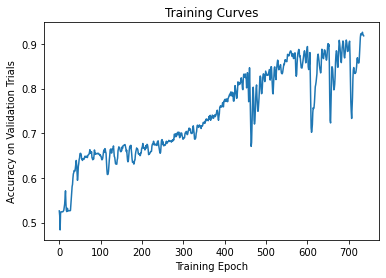

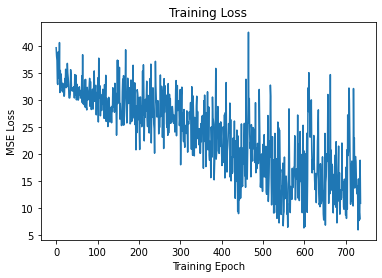

In [ ]:
plt.title("Training Curves")
plt.ylabel("Accuracy on Validation Trials")
plt.xlabel("Training Epoch")
plt.plot(val_acc)

plt.figure()
plt.plot(train_loss)
plt.title("Training Loss")
plt.ylabel("MSE Loss")
plt.xlabel("Training Epoch")

# 5. Visualizing RNN Behavior

## Psychometric Curves
In the following cells, we will implement a way to visualize the psyphysical performance of our RNNs trained on the CDI task. That is, how does the behavior of our model RNN depend on how strongly the dots are moving towards the right or the left. 

We will visualize the fraction of the time our trained RNN reaches towards the right (we will consider a positive output of the RNN to be a reach toward the right and a negative output to be a reach towards the left) as a function of coherence. We will look at how strongly the RNNs behavior is connected to the attended context signal and the ignored context signal. 

In [ ]:
def CountReaches(rnn_outputs, tol=1):
    
    '''
    CountReaches counts how many rightward reaches were made by the RNN. 
    RNN outputs greater than zero are defined as rightward reaches while RNN 
    outputs of less than or equal to zero may be considered as reaches towards
    the left. rnn_outputs are the final RNN outputs for each testing trial.
    
    PARAMETERS
    rnn_outputs: 1D NumPy ndarray
      This is an array with shape (number_of_testing_trials). Each element of 
      this array corresponds to the final decision of an RNN to reach towards 
      the right at trial i (if rnn_output[i] > 0) or to reach towards the
      left on trial i (if rnn_output[i] <= 0). 
    
    RETURNS
    fraction_right : float
      The fraction of all the rnns final outputs that were rightward reaches
    
    '''
    n_test_trials = rnn_outputs.shape[0]
    ########
    ## TODO: 
    ##    Implement a function that counts the total number of reaches the RNN 
    ##    makes towards the right. Without loss of generality, we will consider 
    ##    any positive output of the RNN that is positive to correspond to a  
    ##    rightward reach. Store the fraction of total right reaches in the 
    ##    variable named fraction_right.
    ########

    ## BEGIN SOLUTION
    fraction_right = None
    pass
    total_right_reaches = 0
    for trial_ix in range(n_test_trials):
        if rnn_outputs[trial_ix] > 0:
            total_right_reaches += 1
    fraction_right = total_right_reaches / n_test_trials
    ## END SOLOTUION

    # if there were no test_trials return 0.5 reaches (random chance) to the 
    # right, otherwise return the fraction of rightward reaches
    if n_test_trials == 0:
        fraction_right = 0.5
    else:
        return fraction_right

In [ ]:
def test_coherence(rnn, task, context_choice=0):
    '''Tests a trained RNN on the Context Dependent Integration task with 
    varying levels of coherence. Returns the fraction of times the RNN makes
    reaches towards the right as a function of how coherent/noisy the context 
    inputs are. The p(right reach) data can then be used to generate a plot
    to visualize RNN behavior.
    

    Parameters
    ----------
    rnn : RNN
        trained rnn that will be used to generate behavior
    task : task object
        used to generate data for testing RNN
    context_choice : int
        specifies which input channel/context to test

    Returns
    -------
    numRightReaches : NumPy array
        array of shape (coherence_levels, 1) with the number of rightward reaches for each coherence level
    '''
    # values of coherence to test the RNN, the higher the coherence the stronger
    # the signal representing the movement of the dots
    coherence_vals = 2*np.array([-0.009, -0.09, -0.036, -0.15, 0.009, 0.036, 0.09, 0.15])
    # We will test the RNN over num_trials and compute the fraction of times
    # that the RNN makes a reach towards the right on these trials
    num_trials = 2000
    # will hold the number of rightward reaches for each coherence level
    num_right_reaches = []

    # task_data are the trials at the current coherence level that will be used 
    # to test the RNN. task_data has shape (num_trials, input_size, timesteps)
    task_data = torch.zeros(num_trials, 4, 750).cuda()  
    
    # we will loop over coherence values, for each coherence value we will 
    # randomly generate 2,000 test trials using a special method of task 
    # (called PsychoTest). We will then feed these trials into the RNN and get 
    # the RNNs average performance across these trials to estimate how 
    # accurately the RNN performs at the current level of coherence
    print("testing RNN at varying levels of coherence")
    for _, coherence in tqdm.tqdm(enumerate(coherence_vals)):
        # generates random trials for the current coherence level
        # context choice controls which context the RNN attends to
        for trial_num in range(num_trials):
            task_data[trial_num,:,:] = task.PsychoTest(coherence, context_choice).t()


        ########
        ## TODO: 
        ##    Using the function implemented above, compute the fraction of 
        ##    rightward reaches the RNN makes at this coherence level. Start
        ##    by passing the task_data (which has shape num_trials, input_size,
        ##    timesteps) into the RNN using the RNN.feed() method. 
        ##    
        ##    HINT: recall that the RNN feed method returns a tensor that is
        ##    (num_timesteps, num_trials)
        ##
        ##    We want to pass the networks output for every batch on the final 
        ##    timestep of the trial into the CountReaches function we defined 
        ##    above to get the fraction of reaches that were towards the right 
        ##    for trials at this coherence level.
        ##
        ##    Store the fraction of reaches towards the right in the variable 
        ##    named ReachFraction
        ########

        ## BEGIN SOLUTION
        ReachFraction = None
        pass
        # pass the task data through the RNN
        output = rnn.feed(task_data)
        # take network decisions at terminal timesetp in trial
        network_decisions = output[-1,:]
        # compute the fraction of reaches towards the right using our function
        ReachFraction = CountReaches(network_decisions)
        ## END SOLOTUION
        
        num_right_reaches.append(ReachFraction)
    # end loop over coherence vals

    # format and returns number of rightward reaches
    num_right_reaches = np.array(num_right_reaches).reshape(-1,1)
    assert(num_right_reaches.shape == (len(coherence_vals), 1))
    return num_right_reaches


Run the cell below to define some auxillary functions that will help us visualize the psychophysical curves and generate lines of best fit.

In [ ]:
from scipy.optimize import curve_fit

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)
def linear(x, m, b):
    y = m*x + b
    return (y)

def fit_sigmoid(coherence_vals, reach_data, p0):
    '''fits a sigmoid curve to psychometric data'''
    popt, pcov = curve_fit(sigmoid, coherence_vals, np.squeeze(reach_data), p0, method='dogbox')
    data_fit = sigmoid(np.linspace(min(coherence_vals), max(coherence_vals), 100), *popt)
    return data_fit

def fit_linear(coherence_vals, reach_data, p0):
    '''fits a linear curve to psychometric data'''
    p0 = [max(reach_data), np.median(coherence_vals),1,min(reach_data)] 
    popt, pcov = curve_fit(linear, coherence_vals, np.squeeze(reach_data), method='dogbox')
    data_fit = linear(np.linspace(min(coherence_vals), max(coherence_vals), 100), *popt)
    return data_fit



def Plot(reach_data, plt_title="", ymin=-.1, ymax=1.1, fit='sigmoid', newFig=True, cs='b'):
    '''Plots psychometric data'''

    coherence_vals = 2*np.array([-0.009, -0.09, -0.036, -0.15, 0.009, 0.036, 0.09, 0.15])

    if newFig:     # generate a new figure
        fig_object = plt.figure()   
        axis_object = fig_object.add_subplot(1,1,1)
        axis_object.spines["left"].set_position("center")
        axis_object.spines["bottom"].set_position("center")
        axis_object.spines["right"].set_color("none")
        axis_object.spines["top"].set_color("none")
        axis_object.xaxis.set_label("top")

    # plots RNN data
    plt.scatter(coherence_vals, reach_data, c=cs)

    p0 = [max(reach_data), np.median(coherence_vals),1,min(reach_data)] 
    if fit=="sigmoid":
        data_fit = fit_sigmoid(coherence_vals, reach_data, p0)
    elif fit == "linear":
        data_fit = fit_linear(coherence_vals, reach_data, p0)
    else:
        raise NotImplementedError()

    plt.plot(np.linspace(min(coherence_vals), max(coherence_vals), 100), data_fit, alpha=.5, c=cs)
    
    # adds plot lables
    plt.title(plt_title)
    plt.ylim([ymin, ymax])


Run the cell below to generate psychophysical curves for our trained RNN model

testing RNN at varying levels of coherence


8it [00:06,  1.24it/s]


testing RNN at varying levels of coherence


8it [00:06,  1.22it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 1.0, 'Out of Context')

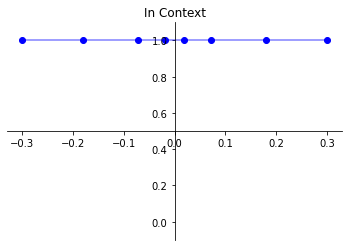

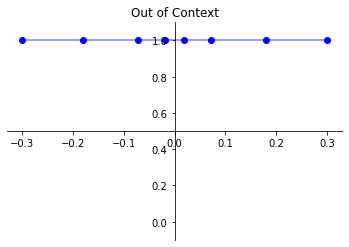

In [ ]:
in_context_reaches = test_coherence(rnn, task, context_choice=0)

out_context_reaches = test_coherence(rnn, task, context_choice=1)

Plot(in_context_reaches, fit='sigmoid')
plt.title("In Context")
Plot(out_context_reaches, fit='linear')
plt.title("Out of Context")

The psychophysical performance curves generated by our model should appear qualitatively similiar to that from monkeys. Below figure taken from [Mante et al., 2013](https://www.nature.com/articles/nature12742). We should observe that there is a sigmoidal relationship between the coherence of the attended context and the RNNs decision to reach towards the right. 

Alterantively, when we vary the coherence in the out of context channel, we should observe that the RNNs motor decisions are only weakly influenced by this.

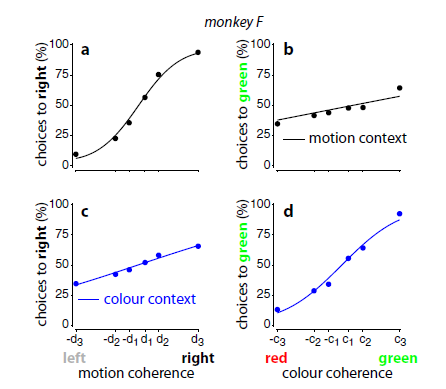

## Visualize attractor States
We provide the folllowing class and auxillary functions to visualize the attractor states and internal dynamics of our trained RNN model. Run the code cell below to import this functionality.

In [ ]:
'''
implementation of fixed point analysis

Author: Brandon McMahan
Date: May 30, 2019
'''

#import numpy as np
#import tensorflow as tf
from scipy.optimize import fsolve
from scipy.optimize import root
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding as LLE
#import matplotlib.pyplot as plt 
import numpy.linalg as LA
#import time
from sklearn.decomposition import PCA
import sys
#from AnhilationPotential import *            #CHANGE THIS 
#import torch
#import pdb
#import numpy as np 
#import rnntools as r
#import pickle

NUM_ITERS = 100

class Roots(object):
    """The fixed points for a trained RNN model.

    Attributes:
        flight_speed     The maximum speed that such a bird can attain.
        nesting_grounds  The locale where these birds congregate to reproduce.

    Methods:
        FindFixedPoints   Solves for the roots
        FindSlowPoints    Solves for regions of slow dynamics
        getNumRoots       Returns number of roots (for a specific input)
        stable            Returns True if root is stable, otherwise False
        plot              Plots the roots in PC space
        save              Saves the roots
        load              Loads roots from file
    """
    def __init__(self, rnn_model=None):

        self._stability = []          # stability of each root found
        self._static_inputs = []      # static input used for each root
        self._values = []             # each element of value will be a numpy array of roots corresponding to a static input #self._values[static_input][root_num] = np.array(that root)
        self._embedded = []           # list of embedded roots
        self._model = rnn_model       # rnn model for which roots will be found
        self._slow_points = []

        # private
        self._progress_fraction = 0

    def FindFixedPoints(self, static_inpts):
        '''Solves for the models fixed points under static input conditions
        
        functions is a list of functions for which we desire to find the roots
        most likley, each function in the list corresponds to a recurrent neural
        network update function, (dx/dt) = F(x), under a different input condition

        Parameters
        ----------
        model : RNN object
            trained model for which we want to find the fixed points.

        Returns
        -------
        TYPE
            DESCRIPTION.

        '''
        rnn_update_eq = self._model.GetF()
        num_static_inpts = len(static_inpts)
        static_inpts = np.array(static_inpts)                                   # inpts is array with shape (num_static_inputs, input_dim)
        num_roots = np.zeros((len(static_inpts), 1+len(static_inpts[0])))              # use this line for non-context tasks
        
        F = []         # holds RNN update functions under different static inputs
        for static_input in static_inpts:
            F.append(rnn_update_eq(static_input))

        
        #find the roots of each desired function
        print('\nSEARCHING FOR ZEROS ... ')
        labels = []
        stability_flag = []                 # denotes stability of fixed point
        for IX, static_input in enumerate(static_inpts):                     # loop over static inputs
            num_roots[IX,:len(static_inpts[0])] = static_input               # update summary table
            self._updateStatusBar()    # reports progress to console
            roots_found = []
            if (not FindZeros(F[IX], roots_found, num_hidden=self._model._hiddenSize)):  # no root found
                print("No root was found !")
                num_roots[IX, -1] = 0
                continue

            unique_roots = GetUnique(roots_found)
            for root in unique_roots:
                self._values.append(root)
                self._static_inputs.append(static_input)
                self._stability.append(IsAttractor(root, F[IX]))

            #curr_roots = self._values[-1]
            num_roots[IX,-1] = len(unique_roots)
            # end loop over roots associated with current static input

    def FindSlowPoints(self):
        '''Solves for the models fixed points under static input conditions
        
        functions is a list of functions for which we desire to find the roots
        most likley, each function in the list corresponds to a recurrent neural
        network update function, (dx/dt) = F(x), under a different input condition

        Parameters
        ----------
        model : RNN object
            trained model for which we want to find the fixed points.

        Returns
        -------
        TYPE
            DESCRIPTION.

        '''
        rnn_update_eq = self._model.GetF()
        num_inputs = self._model._inputSize
        if num_inputs == 4:  # context task
            zero_input = np.zeros((num_inputs, 2))
            zero_input[2, 0] = 1
            zero_input[3, 1] = 1
        elif num_inputs == 6:  # Ncontext task
            zero_input = np.zeros((num_inputs, 3)) #6,3
            zero_input[3, 0] = 1    # GO 1 on
            zero_input[4, 1] = 1    # GO 2 on
            zero_input[5, 2] = 1    # GO 3 on
        else:
            zero_input = np.zeros((num_inputs, 1))
            
        num_slow_regions = zero_input.shape[1]
        for ix in range(num_slow_regions):        
            F = rnn_update_eq(zero_input[:,ix])         
            
            #find all unique roots under zero input condition
            print('\nSEARCHING FOR SLOW POINTS ... ')
            slow_pts = []
            if (not FindZeros(F, slow_pts, num_hidden=self._model._hiddenSize, tol=1)):
                print("Failed to find any slow points")
                return False
            tmp = GetUnique(slow_pts)
            if ix == 0:
                self._slow_points = np.array(tmp)
            else:
                self._slow_points = np.vstack((self._slow_points, np.array(tmp)))
        return True
        
        #self._slow_points = np.squeeze(np.array(self._slow_points))

    def getNumRoots(self, static_input=None):
        '''returns the number of roots corresponding to static_input
        or returns the total number of roots if static_input is none'''
        totalNumRoots = 0
        for static_input_ix in range(len(self._values)):
            currNumRoots = len(self._values[static_input_ix])
            if (self._static_inputs[static_input_ix] == static_input).all():
                return currNumRoots
            else:
                totalNumRoots += currNumRoots
        return totalNumRoots

    def _embed(self, save_fixed_points=False, mean_overide=1, pulse=True):
        # perform PCA on trajectories to get embedding
        cs = ['r', 'r', 'r', 'r', 'r', 'b', 'b', 'b', 'b', 'b']
        # TODO: check that record is working properly inside this function call
        trial_data, self._labels = record(self._model, \
            title='fixed points', print_out=False, plot_recurrent=False, cs=cs,
            mean_overide=mean_overide, pulse=pulse)
        self._model._pca = PCA()
        self._trajectories = self._model._pca.fit_transform(trial_data.reshape(-1, self._model._hiddenSize)).reshape(10,-1,self._model._hiddenSize)
        # model_trajectories is (t_steps, hiddenSize)
        assert(self._trajectories.shape[1]>=self._model._task.N)
        assert(self._trajectories.shape[2]==self._model._hiddenSize)
            
        num_fixed_pts = len(self._values)
        fixed_pts = np.squeeze(np.array(self._values))    # cast fixed points as NumPy array
        if num_fixed_pts == 1:   # must reshape to a single row matrix 
            fixed_pts = fixed_pts.reshape(1,-1)   # data contains a single sample

        if fixed_pts != []:
            roots_embedded = self._model._pca.transform(fixed_pts)
            self._embedded = roots_embedded

    def plot(self, fixed_pts=False, slow_pts=True, plot_traj=True, plot_PC1=False, start_time = 0, end_time=-1):
        '''Plots the embedded fixed points in two dimensions

        Parameters
        ----------
        roots_embedded : NumPy array
            contains the embedded roots along with stability flag (first column) and 
            static_input (second column) has shape (num_roots, 2+hidden_size).

        Returns
        -------
        None.
        '''
        print("0000")
        if self._embedded == []:
            self._embed()
        cs = ['g', 'b', 'r']
        plt.figure()
        if fixed_pts and self._embedded != []:
            n_roots = self._embedded.shape[0]
            if len(self._static_inputs) > 10:  # use high resolution map
                colors = high_res_cmap 
            else:  # use standard color map when there are less than 44 static inputs
                colors = cmap 
            for root_ix in range(n_roots):  # loop over roots
                if self._stability[root_ix]:  # root is stable
                    plt.scatter(self._embedded[root_ix, 0], self._embedded[root_ix, 1], edgecolors=colors(self._static_inputs[root_ix]), alpha=0.5, s=500, facecolors='none', linewidth=3)
                else:    # root is unstable
                    pass # don't plot unstable roots!               
                    #plt.scatter(self._embedded[root_ix, 0], self._embedded[root_ix, 1], marker='x', c=cmap(self._static_inputs[root_ix]), alpha=0.5)
     

        if plot_traj:
            for i in range(10): # plot the trajectories
                if start_time != 0:
                    pass
                    plt.plot(self._trajectories[i,:start_time,0], self._trajectories[i,:start_time,1], c = 'k', alpha=0.1)
                plt.plot(self._trajectories[i,start_time:end_time,0], self._trajectories[i,start_time:end_time,1], c = cs[int(self._labels[i])], alpha=0.25)
            
        if slow_pts:    # plot the slow points
            if self._slow_points == []:    # slow points have not been found yet
                self.FindSlowPoints()
        
            num_slow_pts = len(self._slow_points)
            slow_pts = np.squeeze(np.array(self._slow_points))    # cast slow points as NumPy array
            if num_slow_pts == 1:   # must reshape to a single row matrix 
                slow_pts = slow_pts.reshape(1,-1)
            if slow_pts != []: # if we were able to find any slow points
                slow_embedded = self._model._pca.transform(slow_pts)
                for ix in range(num_slow_pts):
                    plt.scatter(slow_embedded[ix, 0], slow_embedded[ix, 1], c='k', marker='x', alpha=0.1)
        
        if plot_PC1:  # plot PC1 against time
            inpt_colors = ['r', 'g', 'b', 'y', 'm', 'c']
            for ii, mean in enumerate([0, 0.2, 0.6]):
                self._embed(mean_overide=mean, pulse=False)
                for i in range(10):
                    plt.plot(self._trajectories[i,start_time:end_time,0], c = inpt_colors[ii], alpha=0.25)
            

    def save(self, fname):
        fname+= ".pkl"
        with open(fname, 'wb') as output:
            pickle.dump(self, output)

    def load(self, fname):
        fname += ".pkl"
        with open(fname, 'rb') as inpt:
            tmp = pickle.load(inpt)

            self._stability = tmp._stability          # stability of each root found
            self._static_inputs = tmp._static_inputs      # static input used for each root
            self._values = tmp._values             # each element of value will be a numpy array of roots corresponding to a static input #self._values[static_input][root_num] = np.array(that root)
            self._embedded = tmp._embedded           # list of embedded roots
            self._model = tmp._model 
         
    def cluster(self):
        pass

    def _updateStatusBar(self):
        '''updates the status of a task and prints it to console'''
        self._progress_fraction += 1
        sys.stdout.write('\r')
        sys.stdout.write('[%-19s] %.2f%% ' %('='*self._progress_fraction, 5.26*self._progress_fraction))
        sys.stdout.flush()

######################################################################
# Auxillary Functions
######################################################################

def record(model, cs=['r', 'b', 'k', 'g', 'y'], title='', print_out=True, plot_recurrent=True, pulse=True, only_out=False, mean_overide=1):
    '''
    Records from recurrent neurons during an identical input sequence of length 50 while
    plotting the hidden state and activation of output neuron. Will also return hidden states 
    as a list of numpy arrays.
    ------------------
    conditions: a list of input conditions to feed the network. The number of trials is
            equal to the number of elements in conditions. 
    
    print_out: if True this will generate a figure containing a plot of the networks 
            output at each timestep
    
    plot_recurrent: if True this will plot a PSTH of the hidden state for each trial
    
    cs: colors to use for each trial
    
    title: title that will be used for network output plots, recomend setting to the 
            name of the model
    '''
    trial_data = [] #each element will be hidden trajectories for a given trial
    trial_labels = []

    #create new figure if network output requested
    #if print_out:
        #create a new figure to hold outputs for each trial
        #plt.figure()
        #plot_annotated = False
    outputs = []

    model._hiddenInitScale = model._hiddenInitScale * 0

    #loop over conditions to create trials
    for _ in range(10):
        length_of_data=750    #200   #100
        taskData, target = model._task.GetInput(mean_overide=mean_overide)
        if pulse:
            pulse_inputs(taskData)
        trial_labels.append(target)
        #data = np.linspace(conditions[_], conditions[_], length_of_data).reshape(length_of_data,1)
        #data = torch.from_numpy(data).float().cuda()
        #if add_in_noise:
        #    data += 0.01*add_in_noise*torch.randn(data.shape[0], data.shape[1]).cuda()
        model._init_hidden()
        output, hidden = model.feed(torch.unsqueeze(taskData.t(), 0), return_hidden=True)
        #convert output to numpy array
        for lol in range(len(output)):
            output[lol] = output[lol].detach().item()
        output = np.array(output.cpu().detach().numpy())
        outputs.append(output)

        #if a plot of the network output is requested
        if print_out:
            plt.figure(101)
            if target > 0:     # positive trial
                plt.plot(output, c='r', alpha=0.5)
            else:              # negative trial
                plt.plot(output, c='b', alpha=0.5)
            #add labels to plot if not already done
            #if not plot_annotated:
            plt.title('Activity of Output Neuron for ' +str(title)+ ' Model (Pulsed Experiments)')
            plt.xlabel('Time in Trial')
            plt.ylabel('Activation of Output Neuron')
            plot_annotated=True

        # plot multi-unit activity
        data = np.squeeze(np.array(hidden))
        trial_data.append(data)
        if plot_recurrent:
            plt.figure()
            plotMultiUnit(data, normalize_cols=True)

    model._hiddenInitScale = model._hiddenInitScale / 10
    if only_out:
        return np.array(outputs), trial_labels
    else:
        return np.array(trial_data), trial_labels

def FindZeros(F, result, num_hidden=50, tol=1e-8, norm=False):
    '''
    FindZeros takes a function F and will search for zeros
    using randomly generated initial conditions
    '''
    roots_found = []

    for _ in range(NUM_ITERS):
        #random activations on U[-1,1]
        x0 = 10*(np.random.rand(num_hidden,1)-0.5)
        # tolerance changed from 1e-8
        sol = root(F, x0, tol=tol, method='lm')   # lm
        if sol.success == True:
            if norm:
                #if not a zero vector
                if LA.norm(sol.x) != 0:
                    curr_root = np.round( sol.x/LA.norm(sol.x), decimals=3 )
                #else don't take the norm (because it is a zero vector)
                else:
                    curr_root = np.round( sol.x, decimals=3 )
            else:
                curr_root = sol.x
            roots_found.append(curr_root)

    #print('roots found:', roots_found.shape)
    if len(roots_found) == 0: # failed to find any roots
        return False   
    
    for point in roots_found: # add each root found to the results list
        result.append(point)
    return True

def ComputeDistance(point1, point2):
    '''Computes euclidean distance between two points'''
    point_dimension = len(point1)
    squared_distances = 0
    for idx in range(point_dimension):
        squared_distances += (point1[idx] - point2[idx])**2
    distance = np.sqrt(squared_distances)
    return distance

def IsAttractor(fixed_point, F, NumSimulations=25):   #NumSimulations=2500
    '''
    IsAttractor will determine if a fixed point is stable or unstable

    returns True if point is stable and False if point is unstable
    '''
    num_stable_iters = 0
    num_unstable_iters = 0

    #reformat fixed point
    original_shape = fixed_point.shape
    fixed_point = fixed_point.reshape(-1,1)

    for simulation in range(NumSimulations):
        epsilon = 10e-5 * np.random.randn(len(fixed_point), 1)                 #10e-3
        epsilon[1] = 1
        epsilon[10] = 1
        epsilon[11] = -1
        nearby_point = fixed_point+epsilon
        initial_distance = ComputeDistance(nearby_point, fixed_point)
        for iterator in range(100):
            nearby_point += F(nearby_point).reshape(-1,1)
        #end of iterations
        final_distance = ComputeDistance(nearby_point, fixed_point)
        if final_distance > initial_distance:
            num_unstable_iters += 1
            #print('iteration diverged...')
        else:
            num_stable_iters += 1
            #print('iteration converged...')
    #end of simulations
    if num_unstable_iters >= 1:
        return False
    else:
        return True

def cmap(static_inpt, max_inpt=3):
    '''
    generates a color for plotting fixed point found under static_input. Colors 
    are generated from the following look-up table:
        |INPUT (%of max)     COLOR
        |>80                 blue
        |>60                 orange
        |>40                 green
        |>20                 red
        |>0                  purple
        |>-20                brown
        |>-40                pink
        |>-60                grey
        |>-inf               olive
    This color scheme was chosen to maximize contrast over a continuous color 
    gradient. With a continuous color gradient nearby points were difficulty to
    discern. The colors in the lookup table may be changed to further enhance 
    contrast.

    Parameters
    ----------
    static_inpt : float
        input value to network for which current fixed point was found.

    Returns
    -------
    list
        r,g,b color that should be used to plot current fixed points.

    '''
    # create the lookup table 
    lookup = {}
    lookup[-4] = 'tab:blue'
    lookup[-3] = 'tab:orange'
    lookup[-2] = 'tab:green'
    lookup[-1] = 'tab:red'
    lookup[0] = 'tab:purple'
    lookup[1] = 'tab:brown'
    lookup[2] = 'tab:pink'
    lookup[3] = 'tab:gray'
    lookup[4] = 'tab:olive'
    lookup['!'] = 'k'     # special case of exactly zero

    # DETERMINE THE MAXIMUM INPUT VALUE
    # case 1: the static_input is two dimensional as in the multisensory task
    # we just use the maximum of the two channels
    if static_inpt.shape[0] == 4:     # context task
        ix_of_nonzero_inpt = np.nonzero(static_inpt[:2])
        if len(ix_of_nonzero_inpt[0]) == 0:    # both inputs are zero
            static_inpt = 0
        else:
            static_inpt = static_inpt[ix_of_nonzero_inpt][0]
        max_inpt = 0.4
    elif static_inpt.shape[0] == 6:     # Ncontext task
        ix_of_nonzero_inpt = np.nonzero(static_inpt[:3])
        if len(ix_of_nonzero_inpt[0]) == 0:    # both inputs are zero
            static_inpt = 0
        else:
            static_inpt = static_inpt[ix_of_nonzero_inpt][0]
        max_inpt = 0.1857
    elif static_inpt.shape[0] == 1:    # RDM task
        static_inpt = static_inpt[0]
        max_inpt = 0.6
    else:
        # TODO: handle Ncontext tasks
        static_inpt = 0
    # END DETERMINE MAXIMUM INPUT
    if static_inpt == 0:
        return 'k'
    else:
        input_level = int(5*static_inpt / max_inpt)
    if input_level > 4:
        input_level = 4
    elif input_level < -4:
        input_level = -4
    return lookup[input_level]


def high_res_cmap(static_inpt, max_inpt=0.02):
    '''
    generates a color for plotting fixed point found under static_input. Colors 
    go from red (positive inputs) to blue (negative inputs)
    Parameters. This function is only appropriate for plotting the attractors 
    near zero.
    ----------
    static_inpt : float
        input value to network for which current fixed point was found.
    Returns
    -------
    list
        r,g,b color that should be used to plot current fixed points.
    '''
    if static_inpt.shape[0] == 4:     # context task
        ix_of_nonzero_inpt = np.nonzero(static_inpt[:2])
        if len(ix_of_nonzero_inpt[0]) == 0:    # both inputs are zero
            static_inpt = 0
        else:
            static_inpt = static_inpt[ix_of_nonzero_inpt][0]
        max_inpt = 0.02

    elif static_inpt.shape[0] == 1:    # RDM task
        static_inpt = static_inpt[0]
        max_inpt = 0.03
        
    else:   # we don't care about the colors for other tasks
        return [[0, 0, 0]]
    
    # clamps input so RGGB values remain in range
    if static_inpt > max_inpt:
        static_inpt = max_inpt
    elif static_inpt < -max_inpt:
        static_inpt = -max_inpt
        
    if static_inpt == 0:
        return [[0,0,0]]  # return black for THE zero input
    
    m_r = -0.5 / max_inpt
    m_b = 0.5 / max_inpt
    
    r = m_r * static_inpt + 0.5
    b = m_b * static_inpt + 0.5
    g = m_r*0
    return [[r, g, b]]

def pulse_inputs(taskData):
    '''turns inputs off later in trial'''
    if taskData.shape[1] == 4:    # context task
        taskData[400:, :2] = 0    # only uses 400ms pulse
        if taskData[0,2] == 1:
            taskData[:,1] = 0 # turn off out of context input
        else:
            taskData[:,0] = 0
    elif taskData.shape[1] == 1:  # RDM task
        taskData[200:] = 0        # use 200ms pulse
    elif taskData.shape[1] == 6:  # N=3 task
        taskData[400:, :3] = 0    # use 400ms pulse
    elif taskData.shape[1] == 8:  # N=4 task
        taskData[400:, :4] = 0    # use 400ms pulse
    else:
        return False # unable to pulse inputs
    return True  # inputs succesfully pulsed

def GetUnique(points, tol=1e-2):
    '''find all unique points in a set of noisy points'''
    #there must be at least one unique point
    unique_pts = [ [] ]		#list of lists (each list is a list of points corresponding to a unique root)
    clf_pts = []	#will hold indices of points that have already been grouped
    unclf_pts = []

    #first pass--point is classified identically to self
    for idx in range(len(points)):
        pt1 = points[0]
        pt2 = points[idx]
        curr_distance = ComputeDistance(pt1, pt2)
        #if points are close enough together to be considered identical
        if curr_distance < tol:
            #store point idx in classified points
            clf_pts.append(idx)
            #if point not sufficiently far to be considered unique
            unique_pts[0].append(pt2)
        else:
            unclf_pts.append(idx)	#holds the indices of all points that are different from first point

    #keep classifying points untill all points have been classified
    while len(clf_pts) != len(points):
        unique_pts.append([])	#new sub-list of identical points
        unclf_pts_tmp = []		#reset to hold this round of unclassified pts
        pt1 = points[unclf_pts[0]]
        for idx in unclf_pts:
            pt2 = points[idx]
            curr_distance = ComputeDistance(pt1, pt2)
            if curr_distance < tol:
                unique_pts[-1].append(pt2)	#start at zero so pt2=pt1 --> pt1 is included if it is truly unique to all other points
                clf_pts.append(idx)
            else:
                  unclf_pts_tmp.append(idx)
        unclf_pts = unclf_pts_tmp	#reset unclassified points
    for _ in range(len(unique_pts)):
        unique_pts[_] = np.mean(unique_pts[_], axis=0)	#want to average over rows to get one point

    return unique_pts

## Visualize Attractor States and Trajectories
Run the code cell below to visualize the attractor states and trajectories for your trained RNN model. We should observe to line attractors (regions of slow dynamics denoted with shaded grey x's) for each context.


SEARCHING FOR ZEROS ... 
[==                 ] 10.52% 0000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:187: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.



SEARCHING FOR SLOW POINTS ... 

SEARCHING FOR SLOW POINTS ... 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:238: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


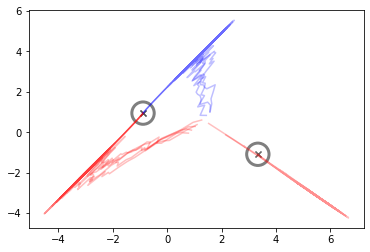

In [ ]:
fixed_point_finder = Roots(rnn_model=rnn)
fixed_point_finder.FindFixedPoints([[0.0,0.0,1,0],[0.0,0.0,0,1]])
fixed_point_finder.plot(fixed_pts=True)